# Filtrowanie danych

Jeszcze bardziej sortuje te dane, zostawiając aby te wyniki, gdzie laski startowały w zawodach RAW i w kategoriach wagowych federacji iPF 

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

my_colors = {'red' : "#B03A2E", 'gray' : "#424949"}

/tmp/ipykernel_88/1195506840.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df_full = pd.read_csv('openpowerlifting.csv', sep=',')
df_female = df_full[df_full['Sex'] == 'F']
df_succesful_best = df_female[df_female['Best3DeadliftKg'] > 0][df_female['Best3SquatKg'] > 0][df_female['Best3BenchKg'] > 0]
df = df_succesful_best
# df.Equipment.unique()
df = df[df['Equipment'].isin(['Raw'])] #tylko raw
df = df[df['Federation'] == 'IPF']
# df

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/tmp/ipykernel_88/2668095244.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_succesful_best = df_female[df_female['Best3DeadliftKg'] > 0][df_female['Best3SquatKg'] > 0][df_female['Best3BenchKg'] > 0]
/tmp/ipykernel_88/2668095244.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_succesful_best = df_female[df_female['Best3DeadliftKg'] > 0][df_female['Best3SquatKg'] > 0][df_female['Best3BenchKg'] > 0]


In [3]:
# df.WeightClassKg.unique()
# weight_class = ['43','47','52','57','63','72','84','84+'] #wszystkie kat wagowe lasek
# # weight_class = ['52','57','63','72','84'] 
# # weight_class = ['57','63','72'] # w tych zawsze są najsilniejsze laski

# df_by_weight = df[df['WeightClassKg'].isin(weight_class)] #tylko kategorie z ipf
# df = df_by_weight

In [4]:
# df_only_dwo_cols = df[["Best3SquatKg","Best3DeadliftKg"]]
# df = df_only_dwo_cols

In [5]:
df["Date"].min(), df["Date"].max() #to chyba jednak nie jest aby 2019 rok XD

('2012-06-12', '2019-01-27')

# Regresja

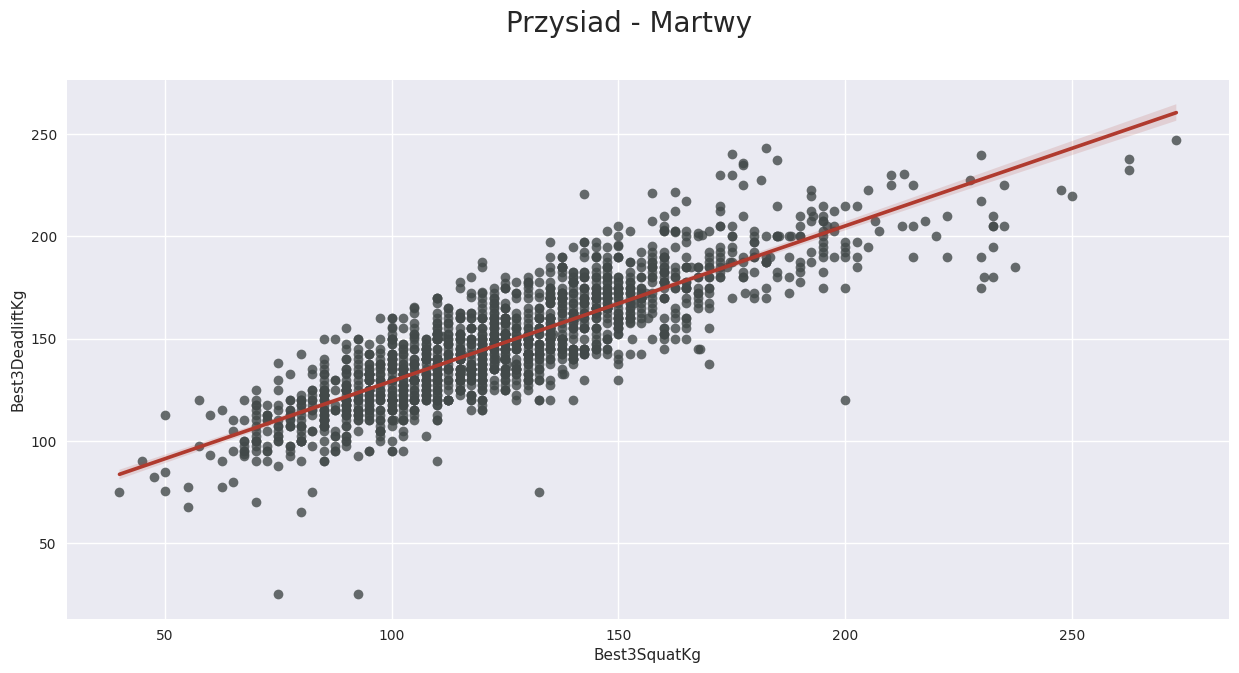

In [6]:
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.regplot(data=df, x='Best3SquatKg', y='Best3DeadliftKg', 
            scatter_kws={"color": my_colors['gray']}, line_kws={"color": my_colors['red']})
plt.suptitle(f'Przysiad - Martwy', fontsize=20);

## z funkcji napisanych przez nas

In [20]:
def print_metrics(column):
    n = len(column)
    print("Średnia: ", np.mean(column))
    print("Mediana: ", np.median(column))
    print("Pierwszy kwartyl: ", np.quantile(column, .25))
    print("Trzeci kwartyl: ", np.quantile(column, .75))
    print("Rozstęp międzykwartylowy: ", np.quantile(column, .75) - np.quantile(column, .25))
    print("Rozstęp: ", np.max(column) - np.min(column))
    print("Wariancja: ", np.var(column))
    print("Odchylenie standardowe: ", np.std(column))
    print("Odchylenie przeciętne od średniej: ", np.mean(np.abs(column - np.mean(column))))
    print("Współczynnik zmienności: ", np.std(column)/np.mean(column))
    print("Współczynnik skośności: " , n/(n-1)/(n-2)*np.sum(((column-np.mean(column))/np.std(column))**3))
    print("Kurtoza: ", ss.kurtosis(column))

def print_reg_metrics(x, y, alpha):
    n = len(x)
    S = np.std(y)
    mx = np.mean(x)
    my = np.mean(y)
    SMD = np.sum((x-mx)**2)
    b1, b0 = np.polyfit(x, y, 1)
    cb0 = ss.t.ppf(q=1-alpha/2, df=n-2)*S*np.sqrt(1/n + (mx**2)/SMD)
    cb1 = ss.t.ppf(q=1-alpha/2, df=n-2)*S/np.sqrt(SMD)
    y_roof = x*b1+b0
    SST = np.sum((y - my)**2)
    SSR = np.sum((y_roof - my)**2)
    SSE = np.sum((y_roof - y)**2)

    print("Beta_0: ", b0)
    print("Beta_1: ", b1)
    print(f"C_Beta_0: [ {b0 - cb0} , {b0 + cb0} ]")
    print(f"C_Beta_1: [ {b1 - cb1} , {b1 + cb1} ]")
    print("SST: ", SST)
    print("SSR: ", SSR)
    print("SSE: ", SSE)
    print("R2: ", SSR/SST)                               # czemu to nie jest z (0,1)? XD
    print("Korelacja Pearsona: ", np.corrcoef(x, y)[0][1])


def regresion(x,y): 
    """
    Funkcja wyznacza współrzędne regresji liniowej metodą najmniejszych kwadratów (MNK)
    Funkcja przyjmuje arrays z danymi
    @x: ciąg współrzędnych z osi x
    @y: współrzędne z osi y

    return:
    @b0: wyraz wolny
    @b1: współczynnik przy x
    """
    n = len(x)
    avg_x = np.mean(x)
    avg_y = np.mean(y)
    b1 = np.sum((x- avg_x)*y) / np.sum((x - avg_x)**2)
    b0 = avg_y - b1*avg_x

    y_roof = x*b1+b0

    return b0,b1,y_roof



In [21]:
#dane
x = np.array(df["Best3SquatKg"])
y = np.array(df["Best3DeadliftKg"])

In [22]:
# liczenie regresji
b0,b1,y_roof = regresion(x,y)

Text(0.5, 0.98, 'Wykres rozproszenia przysiadu do martwego ciągu')

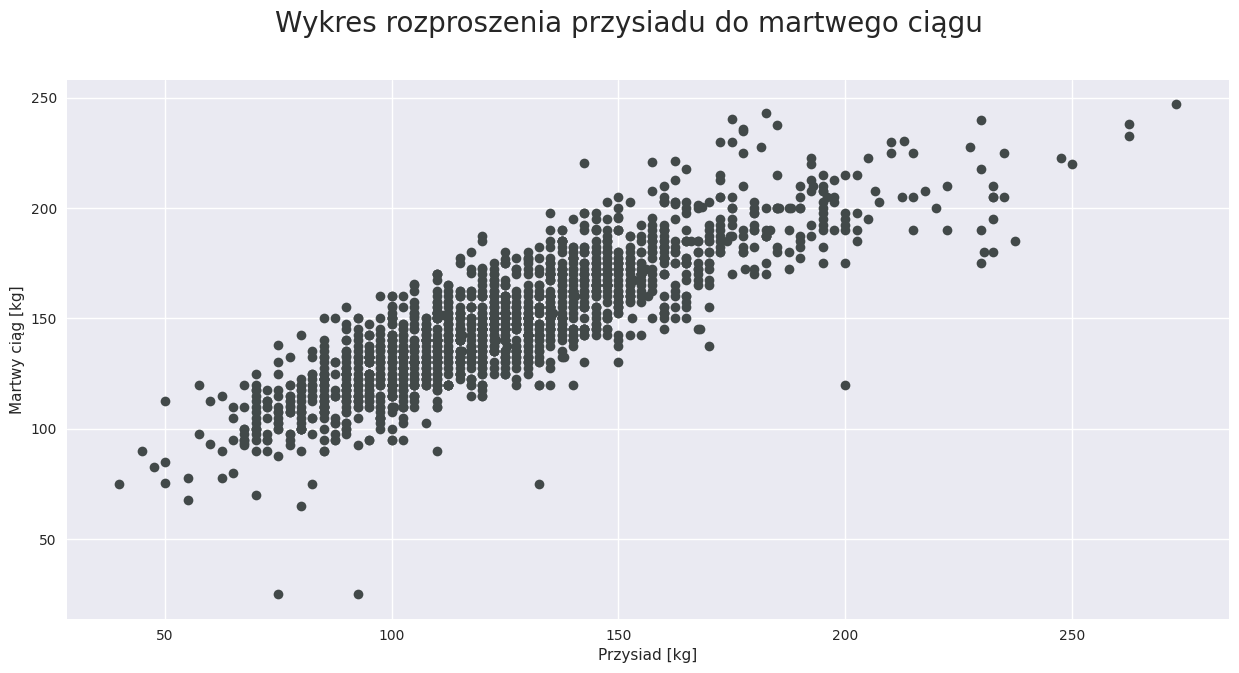

In [23]:
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.scatterplot(data=df, x='Best3SquatKg', y='Best3DeadliftKg', color= my_colors['gray'], linewidth=0) 
plt.xlabel("Przysiad [kg]")
plt.ylabel("Martwy ciąg [kg]")
plt.suptitle("Wykres rozproszenia przysiadu do martwego ciągu", fontsize=20)

# plt.savefig("1//rozproszenie.pdf")

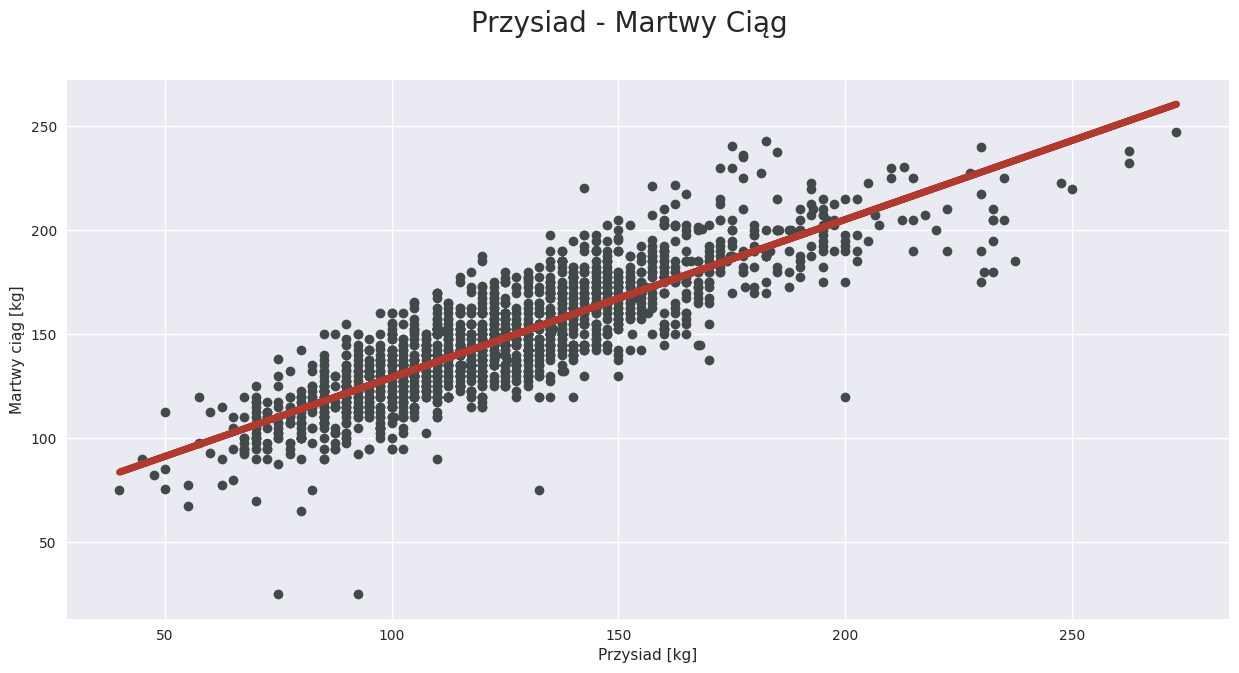

In [24]:
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.scatterplot(data=df, x='Best3SquatKg', y='Best3DeadliftKg', color= my_colors['gray'], linewidth=0) 
plt.plot(x,y_roof, color = my_colors['red'], lw=5)
plt.suptitle(f'Przysiad - Martwy Ciąg', fontsize=20)
plt.xlabel("Przysiad [kg]")
plt.ylabel("Martwy ciąg [kg]")

plt.savefig("3//regression.pdf")

In [25]:
print_reg_metrics(x, y, 0.05)

Beta_0:  53.28916213804863
Beta_1:  0.7591421310063897
C_Beta_0: [ 47.72681763135775 , 58.851506644739516 ]
C_Beta_1: [ 0.7164531324787712 , 0.8018311295340083 ]
SST:  1459676.1003531488
SSR:  1045185.2706143358
SSE:  414490.8297388128
R2:  0.7160391749659171
Korelacja Pearsona:  0.8461909801965022


# Statystyki

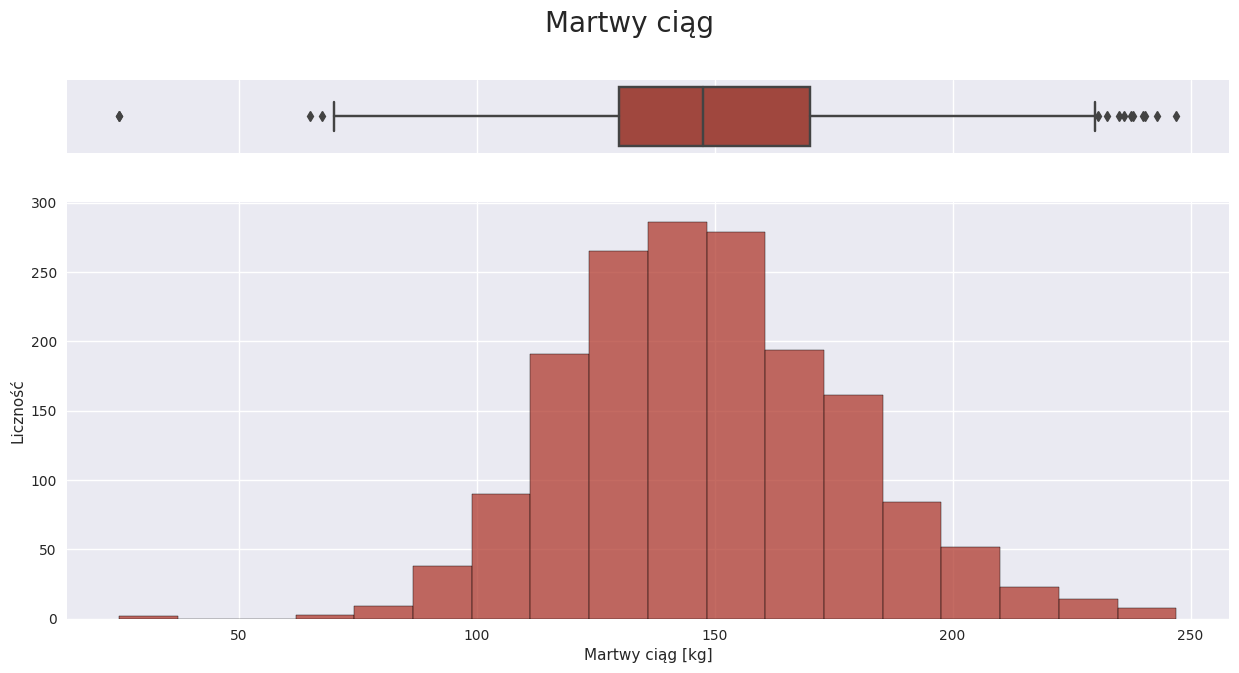

In [13]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 7))
sns.boxplot(data= df, x='Best3DeadliftKg', ax=ax_box, color=my_colors['red'])
sns.histplot(data=df, x='Best3DeadliftKg',bins=18, ax=ax_hist, color=my_colors['red'])
ax_box.set(xlabel='')
ax_hist.set(ylabel='Liczność', xlabel="Martwy ciąg [kg]")
plt.suptitle(f'Martwy ciąg', fontsize=20);
# plt.savefig('2//MC_box_hist.pdf')

In [14]:
min(y)

25.0

In [15]:
print_metrics(y)

Średnia:  149.04473219540907
Mediana:  147.5
Pierwszy kwartyl:  130.0
Trzeci kwartyl:  170.0
Rozstęp międzykwartylowy:  40.0
Rozstęp:  222.0
Wariancja:  859.1383757228657
Odchylenie standardowe:  29.311062343812544
Odchylenie przeciętne od średniej:  23.2148831792132
Współczynnik zmienności:  0.19665949887704515
Współczynnik skośności:  0.228626800666824
Kurtoza:  0.3009803657488348


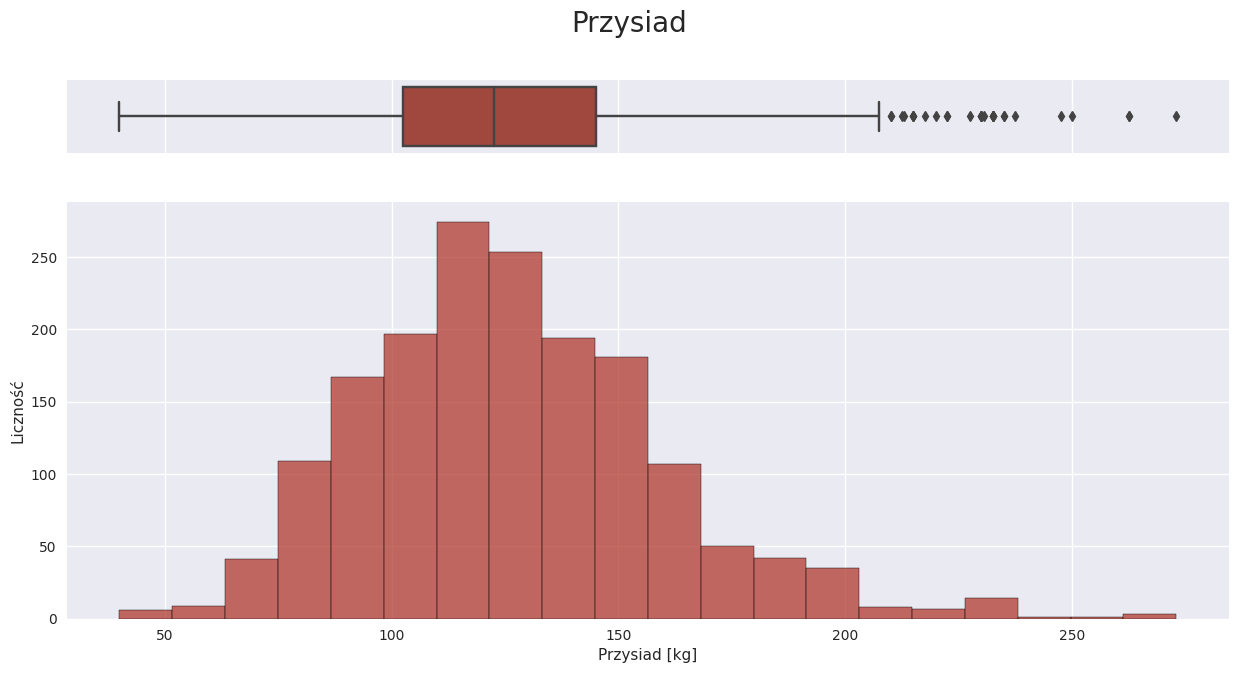

In [16]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15, 7))
sns.boxplot(data= df, x='Best3SquatKg', ax=ax_box, color=my_colors['red'])
sns.histplot(data=df, x='Best3SquatKg',bins=20 , ax=ax_hist, color=my_colors['red'])
ax_box.set(xlabel='')
ax_hist.set(ylabel='Liczność', xlabel='Przysiad [kg]')
plt.suptitle(f'Przysiad', fontsize=20);
# plt.savefig('2//P_box_hist.pdf')

In [17]:
print_metrics(x)

Średnia:  126.13655091230136
Mediana:  122.5
Pierwszy kwartyl:  102.5
Trzeci kwartyl:  145.0
Rozstęp międzykwartylowy:  42.5
Rozstęp:  233.0
Wariancja:  1067.46516785659
Odchylenie standardowe:  32.672085453129405
Odchylenie przeciętne od średniej:  25.415047316896242
Współczynnik zmienności:  0.25902155415558525
Współczynnik skośności:  0.6782617370914693
Kurtoza:  0.9809682063095928


## Predykcja

In [18]:
def pred_conf_int(x_0, x, var):
    return var*np.sqrt(1+1/len(x)+((x_0-np.mean(x))**2)/np.sum((x-np.mean(x))**2))

In [19]:
pred_conf_int(x[0], x, v)

NameError: name 'v' is not defined

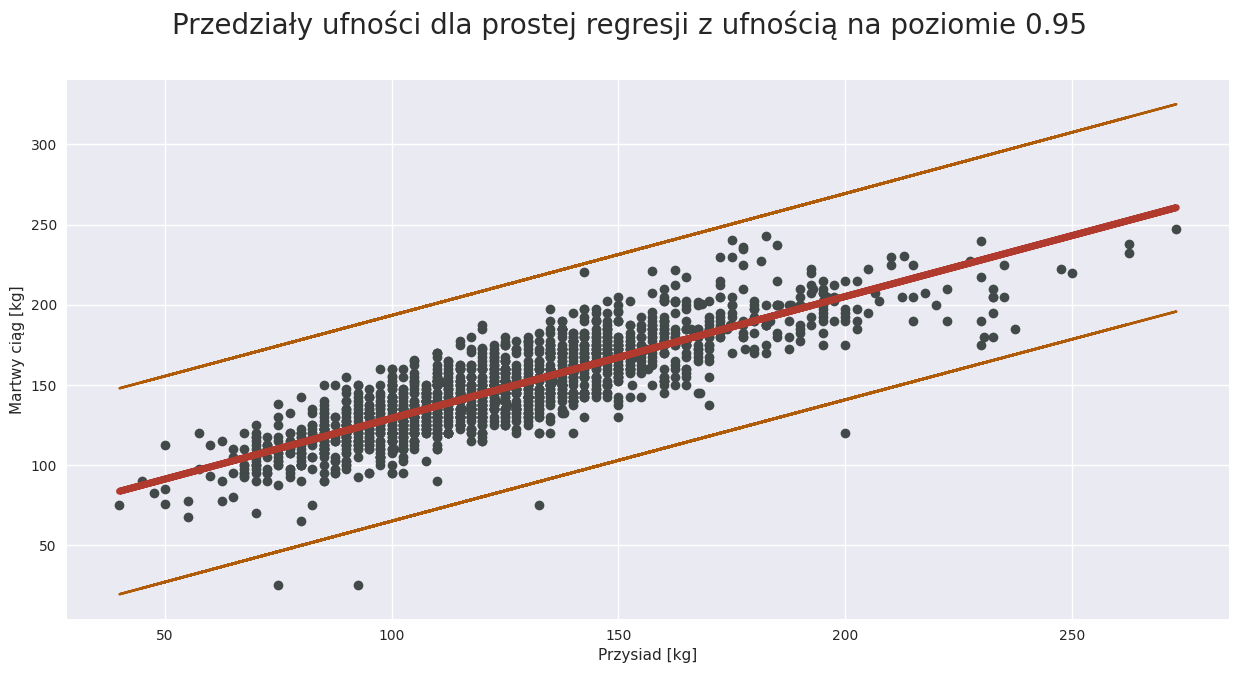

In [54]:
fig, ax = plt.subplots(1, figsize=(15, 7))
sns.scatterplot(data=df, x='Best3SquatKg', y='Best3DeadliftKg', color= my_colors['gray'], linewidth=0) 
plt.plot(x,y_roof, color = my_colors['red'], lw=5)
plt.suptitle('Przedziały ufności dla prostej regresji z ufnością na poziomie 0.95', fontsize=20)
plt.xlabel("Przysiad [kg]")
plt.ylabel("Martwy ciąg [kg]")

n = len(x)
v = np.std(x)
alpha = .05
t = ss.t.ppf(1-alpha/2, n-2)
m = np.mean(x)

pred_up = [y_roof[i]+t*pred_conf_int(x_0, x, v) for i, x_0 in enumerate(x)]
pred_dn = [y_roof-t*pred_conf_int(x_0, x, v) for x_0 in x]

plt.plot(x, pred_up, color='#af5b07')
plt.plot(x, y_roof-t*v*(1+1/n+ (y_roof-m)**2/np.sum((x-m)**2)), color='#af5b07')

plt.savefig("3//confidence_interval_regression.pdf")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=47b01b49-78b6-4c04-a5a6-f968081bf432' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>